---
title: "Offensive Football Plays"
format:
  html:
    toc: true
    toc-depth: 3
    embed-resources: true
    anchor-sections: true
    smooth-scroll: true
---

In [151]:
#!pip install -U imbalanced-learn
#!pip install wandb

In [152]:
import pandas as pd
import numpy as np
import glob

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.sequence import pad_sequences

import wandb
import pprint
from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

In [153]:
RETRAIN_MODEL = False

# 1. Data Access

Load data from NFL Season 2022 which consists of multiple files:

- Plays: all games in 2022
- Players: all active players
- Tracking: tracking information about the players and the ball for each play

Data is taken from the NFL Big Data Bowl 2023: [NFL Big Data Bowl](https://www.kaggle.com/competitions/nfl-big-data-bowl-2023/data)

The whole project including trained models can be found on [GitHub](https://github.com/lz039/nfl)

In [154]:
df_plays = pd.read_csv("data/2022/plays.csv")

# read all files (more data, longer loading times!!)
file_pattern = 'data/2022/tracking_week_*.csv'
file_paths = glob.glob(file_pattern)
dfs = [pd.read_csv(file) for file in file_paths]
df_tracking = pd.concat(dfs, ignore_index=True)

df_players = pd.read_csv('data/2022/players.csv')

# 2. Data Understanding

The aim is to predict the offense formation based on the player's position and other features like yards to the goal.

## Plays

Each game has a unique ID, `gameId`, and contains a list of `playIds` for each play in a game. The `playId` is not unique, only in combination with the `gameId`.<br>
The distribution of the feature to predict, `offenseFormation`, is unbalanced with **SHOTGUN** being the most common formation.

In [155]:
df_plays.head(3)

,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,...,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2
0,2022100908,3537,48723,Parker Hesse,(7:52) (Shotgun) M.Mariota pass short middle t...,4,1,10,ATL,TB,...,0.976785,0.023215,-0.006110,0.006110,2.360609,0.981955,NaN,NaN,NaN,NaN
1,2022091103,3126,52457,Chase Claypool,(7:38) (Shotgun) C.Claypool right end to PIT 3...,4,1,10,PIT,CIN,...,0.160485,0.839515,-0.010865,0.010865,1.733344,-0.263424,NaN,NaN,NaN,NaN
2,2022091111,1148,42547,Darren Waller,(8:57) D.Carr pass short middle to D.Waller to...,2,2,5,LV,LAC,...,0.756661,0.243339,-0.037409,0.037409,1.312855,1.133666,NaN,NaN,NaN,NaN


In [156]:
df_plays[['offenseFormation']].value_counts()

offenseFormation
SHOTGUN             6378
SINGLEBACK          3524
I_FORM               929
EMPTY                850
PISTOL               599
JUMBO                115
WILDCAT               87
dtype: int64

According to football theory, all formations are firmly defined. One formation has not only one but multiple variants where single player positions may vary. See [Wikipedia](https://en.wikipedia.org/wiki/List_of_formations_in_American_football).<br>
<br>
1) Using the **SHOTGUN** formation, the quarterback (QB) lines up five yards behind the center (C) to have enough time to get a pass off, therefore it's mainly a passing formation.<br>Altough the other positions are variable, most of the time there is one running back (HB) near to the quarterback (QB), one tight end (TE) near to the offense and three wide receivers (WR).<br>
![SHOTGUN](formations/shotgun.PNG)<br><br>
2) In the **SINGLEBACK** formation, there is only one back behind the quarterback (QB), normally the running back (HB).<br>
![SINGLEBACK](formations/singleback.PNG)<br><br>
3) The **I-FORMATION** was once the most common formation, altough it got superseded by the **SHOTGUN** formation.<br>"The I" consists of two backs lined up behind the quarterback (QB), with the back closest to the quarterback being called the fullback (FB) and the back behind the fullback called the half back (HB).<br>
![IFORMATION](formations/iformation.PNG)<br><br>
4) The **EMPTY** formation is mostly exclusive for passing plays, as all the backs (HB/FB) play as receivers (TE/WR).<br>
![EMPTY](formations/empty.PNG)<br><br>
5) The **PISTOL** formation is a variant of the **SHOTGUN** formation, where the quarterback (QB) is nearer to the offense line and the running back (in this case half back, HB) stays behind the quarterback (QB). This way the **PISTOL** formation can be used for passing and running plays.<br>
![PISTOL](formations/pistol.PNG)<br><br>
6) The **JUMBO** formation is used exclusively in short-yardage situations, and especially near the goal line. There are no receivers.<br>
![JUMBO](formations/jumbo.PNG)<br><br>
7) The **WILDCAT** formation is mainly a running formation. It looks like the **SHOTGUN** formation but the quarterback (QB) is replaced by a running back (HB) so that more blocking players are available. The ball is directly snapped to the running back.

In [157]:
target_names = df_plays[['offenseFormation']].value_counts().index.get_level_values('offenseFormation').tolist()
target_names

['SHOTGUN', 'SINGLEBACK', 'I_FORM', 'EMPTY', 'PISTOL', 'JUMBO', 'WILDCAT']

In [158]:
df_plays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12486 entries, 0 to 12485
Data columns (total 35 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   gameId                            12486 non-null  int64  
 1   playId                            12486 non-null  int64  
 2   ballCarrierId                     12486 non-null  int64  
 3   ballCarrierDisplayName            12486 non-null  object 
 4   playDescription                   12486 non-null  object 
 5   quarter                           12486 non-null  int64  
 6   down                              12486 non-null  int64  
 7   yardsToGo                         12486 non-null  int64  
 8   possessionTeam                    12486 non-null  object 
 9   defensiveTeam                     12486 non-null  object 
 10  yardlineSide                      12319 non-null  object 
 11  yardlineNumber                    12486 non-null  int64  
 12  game

In [159]:
# Convert gameClock to seconds
df_plays['gameClock'] = '00:' + df_plays['gameClock']
df_plays['gameClock'] = pd.to_timedelta(df_plays['gameClock'])
df_plays['gameClock'] = pd.to_timedelta(df_plays['gameClock']).dt.total_seconds()
df_plays['gameClock'] = df_plays['gameClock'].astype(int)

In [160]:
# convert data types
df_plays['uniquePlayId'] = df_plays['gameId'].astype(str) + df_plays['playId'].astype(str)
df_plays['uniquePlayId'] = df_plays['uniquePlayId'].astype('int64')

`PlayId` and `gameId` is required to match data with the tracking data.<br>
Features were selected according to theory which have influence on the next play and therefore the offense formation.

In [161]:
plays_features = [ 'uniquePlayId', 'gameId', 'playId', 'quarter', 'down', 'yardsToGo', 'gameClock', 'possessionTeam', 'offenseFormation', 'absoluteYardlineNumber' ]
df_plays = df_plays[plays_features]
df_plays.head(3)

,uniquePlayId,gameId,playId,quarter,down,yardsToGo,gameClock,possessionTeam,offenseFormation,absoluteYardlineNumber
0,20221009083537,2022100908,3537,4,1,10,472,ATL,SHOTGUN,69
1,20220911033126,2022091103,3126,4,1,10,458,PIT,SHOTGUN,76
2,20220911111148,2022091111,1148,2,2,5,537,LV,I_FORM,40


## Tracking

As with the **plays** dataset, interesting features were extracted that have influence on the current play.<br>
One unique play in a game consists of 22 players on the field (11 offense, 11 defense).

Theoretically it should be perfectly clear when looking at the initial player positions which offensive formation is used.<br>
These player positions are in the tracking dataset using `x`,`y` coordinates of the field.<br>
They range from 0 - 120 (0-10 own touchdown zone, 10-110 the 100-years field, 110-120 enemy touchdown zone).

<img src="data/fieldimage.png" alt="FOOTBALLFIELD" width="800" height="400">

Looking at the `club` column and matching this information with the `possessionTeam` from the **plays** data, the offensive players can be identified.

In addition to the starting formation (which should be `frameId=1`), there are all the other frames (timestamps) of one play, making it possible to even analyze the time sequence of the play.

There are around 530.000 missing values for `nflId`, this identifies the ball that has a position but no orientation (`o`) of direction (`dir`).

In [162]:
df_tracking.head(3)

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
0,2022090800,56,35472.0,Rodger Saffold,1,2022-09-08 20:24:05.200000,76.0,BUF,left,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN
1,2022090800,56,35472.0,Rodger Saffold,2,2022-09-08 20:24:05.299999,76.0,BUF,left,88.47,27.13,1.67,0.61,0.17,230.98,148.53,pass_arrived
2,2022090800,56,35472.0,Rodger Saffold,3,2022-09-08 20:24:05.400000,76.0,BUF,left,88.56,27.01,1.57,0.49,0.15,230.98,147.05,NaN


In [163]:
df_tracking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12187398 entries, 0 to 12187397
Data columns (total 17 columns):
 #   Column         Dtype  
---  ------         -----  
 0   gameId         int64  
 1   playId         int64  
 2   nflId          float64
 3   displayName    object 
 4   frameId        int64  
 5   time           object 
 6   jerseyNumber   float64
 7   club           object 
 8   playDirection  object 
 9   x              float64
 10  y              float64
 11  s              float64
 12  a              float64
 13  dis            float64
 14  o              float64
 15  dir            float64
 16  event          object 
dtypes: float64(9), int64(3), object(5)
memory usage: 1.5+ GB


In [164]:
df_tracking['uniquePlayId'] = df_tracking['gameId'].astype(str) + df_tracking['playId'].astype(str)
df_tracking['uniquePlayId'] = df_tracking['uniquePlayId'].astype('int64')

In [165]:
tracking_features = ['uniquePlayId', 'gameId', 'playId', 'frameId', 'nflId', 'playDirection', 'x', 'y', 'o', 'dir', 'club']

In [166]:
df_tracking = df_tracking[tracking_features]
df_tracking.isna().sum()

uniquePlayId          0
gameId                0
playId                0
frameId               0
nflId            530060
playDirection         0
x                     0
y                     0
o                528887
dir              528887
club                  0
dtype: int64

In [167]:
# Fill values that identify the ball with 0 to remove NA values.
df_tracking = df_tracking.fillna(0)

In [168]:
# deduplicate feature list
features = tracking_features + plays_features
features = list(set(features))
features

['down',
 'o',
 'offenseFormation',
 'club',
 'uniquePlayId',
 'gameClock',
 'dir',
 'yardsToGo',
 'quarter',
 'possessionTeam',
 'absoluteYardlineNumber',
 'y',
 'frameId',
 'gameId',
 'playDirection',
 'playId',
 'nflId',
 'x']

# 3. Preprocessing

Now all datasets can be merged to have one table with all required information that can be used for machine learning.

It's important not to accidentally lose data during merge operations, therefore the length of the dataframe is printed in between.

In [169]:
df2 = pd.merge(df_tracking, df_plays, on='uniquePlayId', how='left')

In [170]:
df2.rename(columns={'gameId_x': 'gameId', 'playId_x': 'playId'}, inplace=True)
df = df2.drop(columns=['gameId_y', 'playId_y'])

In [171]:
df.head(3)

,uniquePlayId,gameId,playId,frameId,nflId,playDirection,x,y,o,dir,club,quarter,down,yardsToGo,gameClock,possessionTeam,offenseFormation,absoluteYardlineNumber
0,202209080056,2022090800,56,1,35472.0,left,88.37,27.27,231.74,147.90,BUF,1,1,10,900,BUF,SHOTGUN,85
1,202209080056,2022090800,56,2,35472.0,left,88.47,27.13,230.98,148.53,BUF,1,1,10,900,BUF,SHOTGUN,85
2,202209080056,2022090800,56,3,35472.0,left,88.56,27.01,230.98,147.05,BUF,1,1,10,900,BUF,SHOTGUN,85


In [172]:
df['offensivePlayer'] = (df['club'] == df['possessionTeam']).astype('category')
df['offenseFormation'] = df['offenseFormation'].astype('category')

In [173]:
len(df)

12187398

The players position is added for visualizations and better understanding.

In [174]:
df2 = pd.merge(df, df_players, on='nflId', how='left')
df_full = df2.copy()
df = df2.drop(columns=['birthDate', 'weight', 'height', 'collegeName', 'displayName'])

In [175]:
df.head(3)

,uniquePlayId,gameId,playId,frameId,nflId,playDirection,x,y,o,dir,club,quarter,down,yardsToGo,gameClock,possessionTeam,offenseFormation,absoluteYardlineNumber,offensivePlayer,position
0,202209080056,2022090800,56,1,35472.0,left,88.37,27.27,231.74,147.90,BUF,1,1,10,900,BUF,SHOTGUN,85,True,G
1,202209080056,2022090800,56,2,35472.0,left,88.47,27.13,230.98,148.53,BUF,1,1,10,900,BUF,SHOTGUN,85,True,G
2,202209080056,2022090800,56,3,35472.0,left,88.56,27.01,230.98,147.05,BUF,1,1,10,900,BUF,SHOTGUN,85,True,G


In [176]:
df.isna().sum()

uniquePlayId                   0
gameId                         0
playId                         0
frameId                        0
nflId                          0
playDirection                  0
x                              0
y                              0
o                              0
dir                            0
club                           0
quarter                        0
down                           0
yardsToGo                      0
gameClock                      0
possessionTeam                 0
offenseFormation            2185
absoluteYardlineNumber         0
offensivePlayer                0
position                  530060
dtype: int64

It looks like there is some tracking data which does not match the play data because there are **2.185** missing values in `offenseFormation` after the merge, but because there are **12.187.398** rows of data, the missing values can be dropped without a big impact.

In [177]:
df = df.dropna(subset=['offenseFormation'])
len(df)

12185213

# 4. Feature Selection and Extraction

There are now 22 players on the field now for each `gameId`+`playId` (or `uniquePlayId`) and each frame.<br>
The visualization shows the position of all players in the first frame of the **play 1672** in **game 2022091103**.

In [178]:
play1 = df[(df['gameId'] == 2022091103) & (df['playId'] == 1672) & (df['frameId'] == 1)]
play1

,uniquePlayId,gameId,playId,frameId,nflId,playDirection,x,y,o,dir,club,quarter,down,yardsToGo,gameClock,possessionTeam,offenseFormation,absoluteYardlineNumber,offensivePlayer,position
409147,20220911031672,2022091103,1672,1,35449.0,right,75.770000,23.44,273.29,100.05,PIT,2,4,1,76,CIN,I_FORM,75,False,NT
409220,20220911031672,2022091103,1672,1,37104.0,right,75.860000,26.37,286.20,291.33,PIT,2,4,1,76,CIN,I_FORM,75,False,DT
409293,20220911031672,2022091103,1672,1,42654.0,right,73.930000,20.86,87.83,353.65,CIN,2,4,1,76,CIN,I_FORM,75,True,T
409366,20220911031672,2022091103,1672,1,43325.0,right,77.440000,21.89,263.45,136.07,PIT,2,4,1,76,CIN,I_FORM,75,False,ILB
409439,20220911031672,2022091103,1672,1,43400.0,right,77.210000,30.60,248.00,213.70,PIT,2,4,1,76,CIN,I_FORM,75,False,SS
409512,20220911031672,2022091103,1672,1,43510.0,right,74.590000,23.73,85.60,286.63,CIN,2,4,1,76,CIN,I_FORM,75,True,C
409585,20220911031672,2022091103,1672,1,44842.0,right,75.450000,18.14,299.32,90.61,PIT,2,4,1,76,CIN,I_FORM,75,False,OLB
409658,20220911031672,2022091103,1672,1,44860.0,right,67.580000,23.76,86.48,249.14,CIN,2,4,1,76,CIN,I_FORM,75,True,RB
409731,20220911031672,2022091103,1672,1,44877.0,right,75.570000,21.04,264.54,263.50,PIT,2,4,1,76,CIN,I_FORM,75,False,DT
409804,20220911031672,2022091103,1672,1,44878.0,right,76.470000,43.66,304.40,309.40,PIT,2,4,1,76,CIN,I_FORM,75,False,CB


In [179]:
def visualizePlay(df, xmin = 0, xmax = 120, ymin = 0, ymax = 53.3, frameId = 0):
   df_temp = df
   if (frameId > 0):
      df_temp = df[df['frameId'] == frameId]

   plt.figure(figsize=(12, 6))

   # remove the football
   df_temp = df_temp[df_temp['nflId'] != 0.0]
   
   scatter = sns.scatterplot(data=df_temp, x='x', y='y', hue='offensivePlayer', size='frameId', sizes=(300, 300))
   for _, row in df_temp.iterrows():
      scatter.annotate(row['position'], (row['x'], row['y']), textcoords="offset points", xytext=(0,-2), ha='center', fontsize=8)

   absolute_yardline_number = df_temp['absoluteYardlineNumber'].iloc[0]
   plt.axvline(x=absolute_yardline_number, color='red', linestyle='-', linewidth=2)

   plt.xlim(xmin, xmax)
   plt.ylim(ymin, ymax)
   plt.xticks(range(xmin, xmax + 1, 10))

   plt.title('Initial player formation')
   plt.xlabel('x')
   plt.ylabel('y')
   plt.grid(True)

   # remove frameId from legend
   handles, labels = scatter.get_legend_handles_labels()
   scatter.legend(handles=handles[:-2], labels=labels[:-2], loc='upper right')

   plt.show()

The play is classified as **I-FORMATION**. Compared to the theory, there is the quarterback (QB) right behind the Center (C) and the running back (in this case RB) some yards behind. Instead of two wide receivers (WR) there are two tight ends (TE) that can also act as receivers.<br>
As a first conclusion, the classification and real formation is often difficult to match completely, as each team has it's own small variations. 
<br>
![IFORMATION](formations/iformation.PNG)

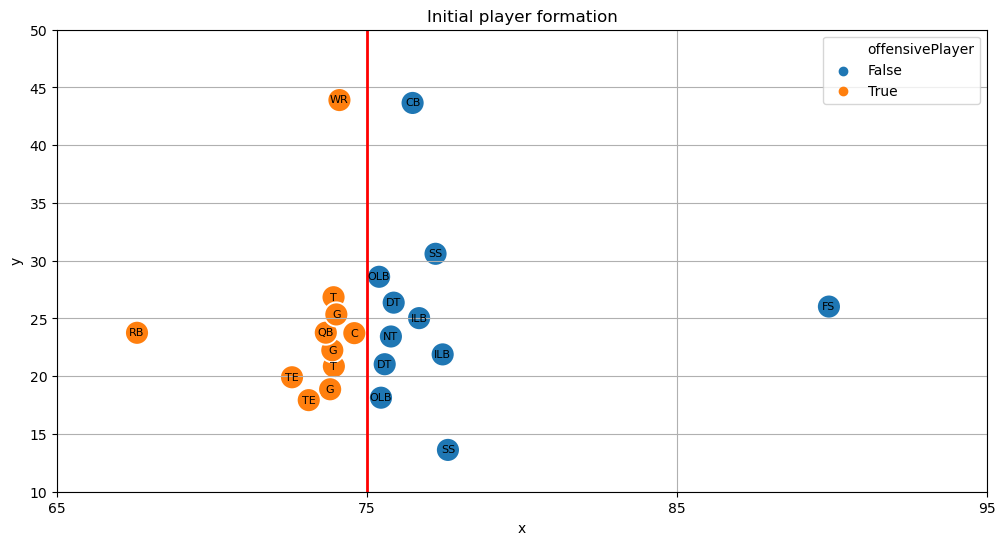

In [180]:
visualizePlay(play1, xmin = 65, xmax = 95, ymin=10, ymax=50)

In [181]:
play2 = df[(df['gameId'] == 2022091103) & (df['playId'] == 58) & (df['frameId'] == 1)]

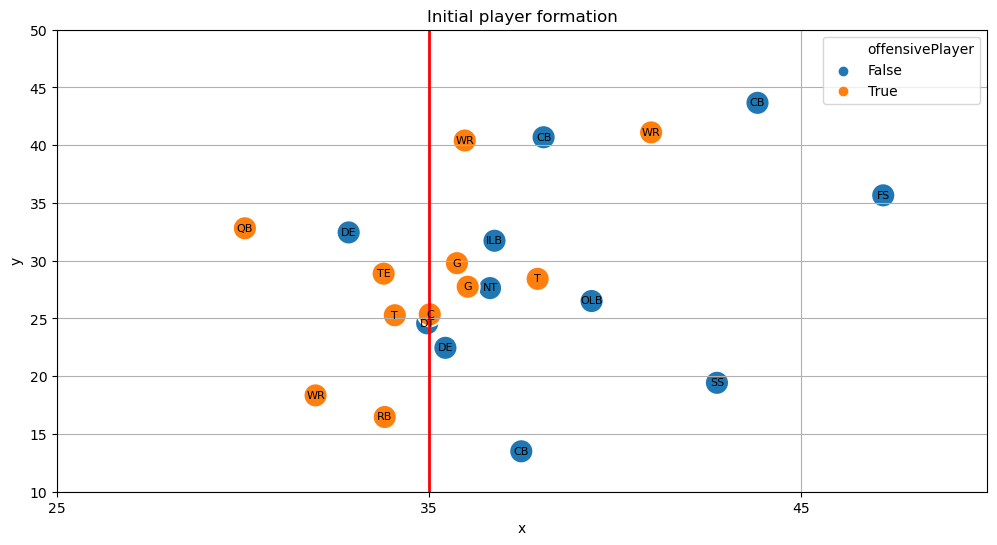

In [182]:
visualizePlay(play2, xmin=25, xmax=50, ymin=10, ymax=50)

The first visualization is correct but the second one is not a starting formation.<br>
The dataframe can be filtered so there are only clean starting positions.

To visualize more than one play at a time, all plays are grouped by `uniquePlayId` and `offenseFormation`.<br>
After that, one example for each offense formation is taken.

Basically there is a filter which checks that each player is behind the line of scrimmage (the red line above), as each player (offense and defense) must be *behind* this line on their respective side before the play can start (before the snap of the ball).

A lot of values are dropped with this operation. (**207.020** to **89.070**), therefore further experiments are required which dataset will perform better.

In [183]:
def keepOnlyStartPositions(df):
    df_filtered = df[df['frameId'] == 1].groupby('playId').apply(lambda group: group[((group['playDirection'] == 'left') & (group['offensivePlayer'] == True) & (group['x'] > group['absoluteYardlineNumber'])) | (group['playDirection'] == 'right') & (group['offensivePlayer'] == True) & (group['x'] < group['absoluteYardlineNumber']) | ((group['playDirection'] == 'left') & (group['offensivePlayer'] == False) & (group['x'] < group['absoluteYardlineNumber'])) | ((group['playDirection'] == 'left') & (group['offensivePlayer'] == False) & (group['x'] < group['absoluteYardlineNumber']))])
    return df_filtered.reset_index(drop=True)

In [184]:
df[df['frameId'] == 1].count()[0]

287020

In [185]:
df_filtered = keepOnlyStartPositions(df)
df_filtered.count()[0]

169207

In [186]:
# filter where we have less players than expected
df_filtered['player_count'] = df_filtered.groupby('uniquePlayId')['uniquePlayId'].transform('count')
df_filtered = df_filtered[df_filtered['offensivePlayer'] == True]
df_filtered = df_filtered[df_filtered['player_count'] > 10]
df_filtered = df_filtered.drop(columns=['player_count'])
df_filtered.count()[0]

89070

In [187]:
playsByFormation = df_filtered.groupby(['uniquePlayId', 'offenseFormation']).agg(list).reset_index().dropna()
playsByFormation.head(5)

,uniquePlayId,offenseFormation,gameId,playId,frameId,nflId,playDirection,x,y,o,dir,club,quarter,down,yardsToGo,gameClock,possessionTeam,absoluteYardlineNumber,offensivePlayer,position
4,202209080056,SHOTGUN,"[2022090800, 2022090800, 2022090800, 202209080...","[56, 56, 56, 56, 56, 56, 56]","[1, 1, 1, 1, 1, 1, 1]","[35472.0, 42392.0, 44875.0, 46076.0, 47857.0, ...","[left, left, left, left, left, left, left]","[88.37, 88.25, 89.42, 90.75, 88.17, 90.22, 91.96]","[27.27, 28.74, 25.81, 30.01, 24.17, 32.08, 33.01]","[231.74, 244.21, 242.67, 299.06, 325.95, 103.2...","[147.9, 30.29, 65.25, 301.11, 238.13, 115.97, ...","[BUF, BUF, BUF, BUF, BUF, BUF, BUF]","[1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1]","[10, 10, 10, 10, 10, 10, 10]","[900, 900, 900, 900, 900, 900, 900]","[BUF, BUF, BUF, BUF, BUF, BUF, BUF]","[85, 85, 85, 85, 85, 85, 85]","[True, True, True, True, True, True, True]","[G, C, T, QB, RB, C, T]"
7,202209080080,EMPTY,"[2022090800, 2022090800, 2022090800, 202209080...","[80, 80, 80, 80, 80, 80, 80]","[1, 1, 1, 1, 1, 1, 1]","[35472.0, 42392.0, 44875.0, 46076.0, 47857.0, ...","[left, left, left, left, left, left, left]","[82.42, 81.75, 82.93, 83.8, 84.18, 85.59, 86.28]","[26.13, 28.39, 24.59, 30.14, 45.45, 29.63, 33.25]","[196.42, 271.2, 246.66, 288.71, 222.73, 117.12...","[140.67, 344.32, 131.4, 294.2, 340.61, 119.97,...","[BUF, BUF, BUF, BUF, BUF, BUF, BUF]","[1, 1, 1, 1, 1, 1, 1]","[2, 2, 2, 2, 2, 2, 2]","[4, 4, 4, 4, 4, 4, 4]","[869, 869, 869, 869, 869, 869, 869]","[BUF, BUF, BUF, BUF, BUF, BUF, BUF]","[79, 79, 79, 79, 79, 79, 79]","[True, True, True, True, True, True, True]","[G, C, T, QB, RB, C, T]"
15,202209110078,I_FORM,"[2022091100, 2022091100, 2022091100, 202209110...","[78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[39975.0, 41232.0, 42345.0, 45550.0, 46992.0, ...","[right, right, right, right, right, right, rig...","[38.21, 44.99, 44.69, 45.18, 45.12, 45.21, 45....","[23.56, 26.91, 23.69, 25.23, 15.05, 22.3, 20.8...","[80.81, 86.24, 75.59, 85.01, 74.88, 69.5, 55.2...","[213.33, 216.65, 180.72, 57.39, 191.75, 38.38,...","[ATL, ATL, ATL, ATL, ATL, ATL, ATL, ATL, ATL, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]","[859, 859, 859, 859, 859, 859, 859, 859, 859, ...","[ATL, ATL, ATL, ATL, ATL, ATL, ATL, ATL, ATL, ...","[46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46]","[True, True, True, True, True, True, True, Tru...","[RB, T, QB, T, WR, G, T, WR, TE, WR, C]"
25,202209110286,SHOTGUN,"[2022091102, 2022091102, 2022091102, 202209110...","[86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[43345.0, 46276.0, 46522.0, 47856.0, 48159.0, ...","[left, left, left, left, left, left, left, lef...","[88.19, 88.92, 87.94, 92.51, 87.47, 89.37, 87....","[28.34, 21.53, 23.73, 27.65, 29.99, 26.51, 43....","[272.45, 296.62, 291.47, 294.87, 253.54, 249.3...","[203.7, 183.62, 293.95, 246.86, 1.41, 183.42, ...","[CHI, CHI, CHI, CHI, CHI, CHI, CHI, CHI, CHI, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]","[889, 889, 889, 889, 889, 889, 889, 889, 889, ...","[CHI, CHI, CHI, CHI, CHI, CHI, CHI, CHI, CHI, ...","[87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87]","[True, True, True, True, True, True, True, Tru...","[G, WR, WR, RB, C, TE, WR, QB, T, T, T]"
33,202209110458,SINGLEBACK,"[2022091104, 2022091104, 2022091104, 202209110...","[58, 58, 58, 58, 58, 58, 58, 58]","[1, 1, 1, 1, 1, 1, 1, 1]","[43290.0, 43305.0, 46089.0, 47791.0, 52443.0, ...","[left, left, left, left, left, left, left, left]","[93.09, 93.78, 89.83, 85.16, 91.46, 92.65, 90....","[30.71, 28.02, 33.75, 41.78, 15.07, 29.24, 33....","[210.63, 285.66, 46.47, 101.0, 288.63, 264.32,...","[30.42, 47.23, 354.53, 313.28, 201.69, 76.76, ...","[DET, DET, DET, DET, DET, DET, DET, DET]","[1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1]","[10, 10, 10, 10, 10, 10, 10, 10]","[900, 90

In [188]:
result_df = playsByFormation.drop_duplicates(subset='offenseFormation')
result_df = result_df.sort_values(by='offenseFormation').reset_index(drop=True)
result_df

,uniquePlayId,offenseFormation,gameId,playId,frameId,nflId,playDirection,x,y,o,dir,club,quarter,down,yardsToGo,gameClock,possessionTeam,absoluteYardlineNumber,offensivePlayer,position
0,202209080080,EMPTY,"[2022090800, 2022090800, 2022090800, 202209080...","[80, 80, 80, 80, 80, 80, 80]","[1, 1, 1, 1, 1, 1, 1]","[35472.0, 42392.0, 44875.0, 46076.0, 47857.0, ...","[left, left, left, left, left, left, left]","[82.42, 81.75, 82.93, 83.8, 84.18, 85.59, 86.28]","[26.13, 28.39, 24.59, 30.14, 45.45, 29.63, 33.25]","[196.42, 271.2, 246.66, 288.71, 222.73, 117.12...","[140.67, 344.32, 131.4, 294.2, 340.61, 119.97,...","[BUF, BUF, BUF, BUF, BUF, BUF, BUF]","[1, 1, 1, 1, 1, 1, 1]","[2, 2, 2, 2, 2, 2, 2]","[4, 4, 4, 4, 4, 4, 4]","[869, 869, 869, 869, 869, 869, 869]","[BUF, BUF, BUF, BUF, BUF, BUF, BUF]","[79, 79, 79, 79, 79, 79, 79]","[True, True, True, True, True, True, True]","[G, C, T, QB, RB, C, T]"
1,202209110078,I_FORM,"[2022091100, 2022091100, 2022091100, 202209110...","[78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[39975.0, 41232.0, 42345.0, 45550.0, 46992.0, ...","[right, right, right, right, right, right, rig...","[38.21, 44.99, 44.69, 45.18, 45.12, 45.21, 45....","[23.56, 26.91, 23.69, 25.23, 15.05, 22.3, 20.8...","[80.81, 86.24, 75.59, 85.01, 74.88, 69.5, 55.2...","[213.33, 216.65, 180.72, 57.39, 191.75, 38.38,...","[ATL, ATL, ATL, ATL, ATL, ATL, ATL, ATL, ATL, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]","[859, 859, 859, 859, 859, 859, 859, 859, 859, ...","[ATL, ATL, ATL, ATL, ATL, ATL, ATL, ATL, ATL, ...","[46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46]","[True, True, True, True, True, True, True, Tru...","[RB, T, QB, T, WR, G, T, WR, TE, WR, C]"
2,202209150097,JUMBO,"[2022091500, 2022091500, 2022091500, 202209150...","[97, 97, 97, 97, 97, 97, 97, 97]","[1, 1, 1, 1, 1, 1, 1, 1]","[42511.0, 43367.0, 44822.0, 46152.0, 46213.0, ...","[left, left, left, left, left, left, left, left]","[79.92, 76.02, 76.69, 76.35, 76.18, 76.05, 82....","[31.64, 28.14, 29.76, 26.66, 25.55, 33.51, 29....","[285.09, 270.83, 258.83, 270.6, 277.02, 249.28...","[233.64, 4.63, 249.38, 65.52, 347.52, 45.95, 2...","[KC, KC, KC, KC, KC, KC, KC, KC]","[1, 1, 1, 1, 1, 1, 1, 1]","[3, 3, 3, 3, 3, 3, 3, 3]","[1, 1, 1, 1, 1, 1, 1, 1]","[831, 831, 831, 831, 831, 831, 831, 831]","[KC, KC, KC, KC, KC, KC, KC, KC]","[76, 76, 76, 76, 76, 76, 76, 76]","[True, True, True, True, True, True, True, True]","[FB, G, QB, T, WR, G, RB, TE]"
3,202209180780,PISTOL,"[2022091807, 2022091807, 2022091807, 202209180...","[80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[41232.0, 41808.0, 42345.0, 45550.0, 47797.0, ...","[left, left, left, left, left, left, left, lef...","[76.14, 77.22, 79.74, 75.92, 75.55, 75.71, 78....","[20.65, 28.26, 23.78, 22.34, 25.13, 26.88, 23....","[267.89, 280.11, 249.16, 281.57, 251.01, 254.1...","[344.14, 45.26, 113.96, 84.85, 6.37, 194.14, 1...","[ATL, ATL, ATL, ATL, ATL, ATL, ATL, ATL, ATL, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]","[862, 862, 862, 862, 862, 862, 862, 862, 862, ...","[ATL, ATL, ATL, ATL, ATL, ATL, ATL, ATL, ATL, ...","[75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75]","[True, True, True, True, True, True, True, Tru...","[T, FB, QB, T, G, T, WR, TE, C, WR, RB]"
4,202209080056,SHOTGUN,"[2022090800, 2022090800, 2022090800, 202209080...","[56, 56, 56, 56, 56, 56, 56]","[1, 1, 1, 1, 1, 1, 1]","[35472.0, 42392.0, 44875.0, 46076.0, 47857.0, ...","[left, left, left, left, left, left, left]","[88.37, 88.25, 89.42, 90.75, 88.17, 90.22, 91.96]","[27.27, 28.74, 25.81, 30.01, 24.17, 32.08, 33.01]","[231.74, 244.21, 242.67, 299.06, 325.95, 103.2...","[147.9, 30.29, 65.25, 301.11, 238.13, 115.97, ...","[BUF, BUF, BUF, BUF, BUF, BUF, BUF]","[1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1]","[10, 10, 10, 10, 10, 10, 10]","[900, 900, 900,

In [5]:
def visualizePlay2(df, facet='offenseFormation'):
    df_expanded = df.apply(pd.Series.explode)

    fig = px.scatter(
        df_expanded, 
        x='x', 
        y='y', 
        color='position',
        text='position',
        facet_col=facet,  # Facet by 'offenseFormation'
        facet_col_wrap=4,  # Adjust the number of columns in the facet grid as needed
        facet_row_spacing=0.1
    )

    fig.add_shape(
        dict(
            type='line',
            x0='absoluteYardlineNumber',
            x1='absoluteYardlineNumber',
            y0=0,
            y1=53.3,
            line=dict(color='red', width=2)
        )
    )

    fig.update_xaxes(range=[0, 120])  # maximum x-axis
    fig.update_yaxes(range=[0, 53.3])  # maximum y-axis
    fig.update_xaxes(dtick=10)

    fig.update_layout(
        title='Initial player formation offense',
        xaxis_title='x',
        yaxis_title='y',
        showlegend=True
    )

    fig.show()

In [3]:
# The visualizations were created with plotly but plotly doesn't work together with quarto
# visualizePlay2(result_df)

Overview of filtered offense formations:

- **EMPTY** as expected, no running backs (no RB), only receivers (WR) and the quarterback (QB).<br>
![EMPTY](formations/p_empty.png)  
- **I_FORM** as expected, with one tight end (TE) and running back (RB) behind the quarterback (QB).<br>
![IFORM](formations/p_iform.png)
- **JUMBO** as expected, no receivers (no WR)<br>
![JUMBO](formations/p_jumbo.png)
- **PISTOL** with running back (RB) behind the quarterback (QB), a variant with one wide receiver (WR) near to the quarterback (QB) and one fullback (FB) in the front.<br>
![PISTOL](formations/p_pistol.png)
- **SHOTGUN** as expected, one running back (RB) near to the quarterback (QB), three receivers (WR)<br>
![SHOTGUN](formations/p_shotgun.png)
- **SINGLEBACK** as expected, only one running back (RB)<br>
![SINGLE](formations/p_single.png)
- **WILDCAT** as expected, there is an additional running back (RB) at the default quarterback (QB) position.<br>
![WILDCAT](formations/p_wildcat.png)

Because the data was filtered for offensivePlayers only, columns with no additional information can be dropped, like:

- `gameId` + `playId` is `uniquePlayId`
- `playDirection` is always in the `offensivePlayer`'s direction
- `club` and `possessionTeam` was only used to find out the offensivePlayers
- `frameId` is always 1
- `offensivePlayer` is always True
  
For the use with machine learning algorithms, all categorical values have to be encoded.

In [195]:
df_filtered.head()

,uniquePlayId,gameId,playId,frameId,nflId,playDirection,x,y,o,dir,club,quarter,down,yardsToGo,gameClock,possessionTeam,offenseFormation,absoluteYardlineNumber,offensivePlayer,position
16,202210130054,2022101300,54,1,44068.0,left,89.03,24.40,243.25,103.39,CHI,1,1,10,900,CHI,SHOTGUN,85,True,G
17,202210130054,2022101300,54,1,46276.0,left,87.93,41.31,165.95,115.80,CHI,1,1,10,900,CHI,SHOTGUN,85,True,WR
18,202210130054,2022101300,54,1,47856.0,left,90.56,14.49,277.07,188.40,CHI,1,1,10,900,CHI,SHOTGUN,85,True,RB
20,202210130054,2022101300,54,1,48159.0,left,89.69,26.85,63.94,56.50,CHI,1,1,10,900,CHI,SHOTGUN,85,True,C
22,202210130054,2022101300,54,1,53440.0,left,91.95,23.84,60.34,107.06,CHI,1,1,10,900,CHI,SHOTGUN,85,True,QB


In [196]:
df_filtered['offenseFormation'].value_counts()

SHOTGUN       38699
SINGLEBACK    31605
I_FORM         8512
PISTOL         5218
EMPTY          3134
JUMBO          1084
WILDCAT         818
Name: offenseFormation, dtype: int64

In [197]:
df_filtered.drop(columns=['gameId', 'playId', 'playDirection', 'club', 'possessionTeam', "frameId", "offensivePlayer"], inplace=True)

In [198]:
label_encoder = LabelEncoder()
df['offenseFormation'] = label_encoder.fit_transform(df['offenseFormation'])
df['position'] = label_encoder.fit_transform(df['position'])

df_filtered['offenseFormation'] = label_encoder.fit_transform(df_filtered['offenseFormation'])
df_filtered['position'] = label_encoder.fit_transform(df_filtered['position'])

In [199]:
df_filtered

,uniquePlayId,nflId,x,y,o,dir,quarter,down,yardsToGo,gameClock,offenseFormation,absoluteYardlineNumber,position
16,202210130054,44068.0,89.03,24.40,243.25,103.39,1,1,10,900,4,85,4
17,202210130054,46276.0,87.93,41.31,165.95,115.80,1,1,10,900,4,85,13
18,202210130054,47856.0,90.56,14.49,277.07,188.40,1,1,10,900,4,85,9
20,202210130054,48159.0,89.69,26.85,63.94,56.50,1,1,10,900,4,85,0
22,202210130054,53440.0,91.95,23.84,60.34,107.06,1,1,10,900,4,85,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
169172,20220911034872,46094.0,54.58,43.58,148.57,342.99,5,1,10,105,4,54,12
169174,20220911034872,46163.0,55.40,35.03,0.11,347.98,5,1,10,105,4,54,4
169175,20220911034872,47794.0,60.84,27.12,233.74,253.44,5,1,10,105,4,54,11
169176,20220911034872,52409.0,60.42,30.45,354.77,204.71,5,1,10,105,4,54,8


For each play there is now one row for each player.<br>
Because only the first frame was selected, one row is basically the starting position of one player.

In [200]:
y_filtered = df_filtered.pop('offenseFormation')
y_filtered.value_counts()

4    38699
5    31605
1     8512
3     5218
0     3134
2     1084
6      818
Name: offenseFormation, dtype: int64

Careful!! The `LabelEncoder` took different values than one would expect in the `target_names` list.<br>
Therefore the list of `target_names` has to be rearranged to match the indices of the encoded values.

- **SHOTGUN**    38699 => 4
- **SINGLEBACK**    31605 => 5
- **I_FORM**     8512 => 1
- **PISTOL**     5218 => 3
- **EMPTY**     3134 => 0
- **JUMBO**     1084 => 2
- **WILDCAT**      818 => 6

In [201]:
target_names = ['EMPTY', 'I_FORM', 'JUMBO', 'PISTOL', 'SHOTGUN', 'SINGLEBACK', 'WILDCAT']

The original dataframe is brought to the same format as `df_filtered`.

In [202]:
df_filtered.head()

,uniquePlayId,nflId,x,y,o,dir,quarter,down,yardsToGo,gameClock,absoluteYardlineNumber,position
16,202210130054,44068.0,89.03,24.40,243.25,103.39,1,1,10,900,85,4
17,202210130054,46276.0,87.93,41.31,165.95,115.80,1,1,10,900,85,13
18,202210130054,47856.0,90.56,14.49,277.07,188.40,1,1,10,900,85,9
20,202210130054,48159.0,89.69,26.85,63.94,56.50,1,1,10,900,85,0
22,202210130054,53440.0,91.95,23.84,60.34,107.06,1,1,10,900,85,8


In [203]:
df.drop(columns=['gameId', 'playId', 'playDirection', 'club', 'possessionTeam', "offensivePlayer"], inplace=True)

In [204]:
y = df.pop('offenseFormation')

It is not completely certain wether the dropped features are really of no impact for the model, more experiments would be necessary.<br>
Because the machine learning with all data takes a long time to process, those additional experiments were not tried. 

# 5. Machine Learning
Two experiments are conducted, one with the filtered data where there are only the cleaned offense formations and the first `frameId`, and another one with all the data.

In [205]:
Xf_train, Xf_test, yf_train, yf_test = train_test_split(df_filtered, y_filtered, test_size=0.3, random_state=42)

In [206]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=42)

In [207]:
X_train.columns

Index(['uniquePlayId', 'frameId', 'nflId', 'x', 'y', 'o', 'dir', 'quarter',
       'down', 'yardsToGo', 'gameClock', 'absoluteYardlineNumber', 'position'],
      dtype='object')

## 5.1 Random Forest

A simple `RandomForest` classifier is used to get feature importances.<br>
Instead of pre-computing class weights, `SMOTE` (*Synthetic Minority Over-sampling Technique*) is used to find out the weights during training.<br>
`SMOTE` creates synthetic samples of the minority class, effectively oversampling the minority class.<br>
This is required because the dataset has unbalanced data as noted during data understanding.

In [208]:
def trainRandomForestWithSMOTE(X_train, y_train):        
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    return model

In [212]:
if (RETRAIN_MODEL):
    model = trainRandomForestWithSMOTE(X_train, y_train)
    feature_importances = model.feature_importances_

    modelf = trainRandomForestWithSMOTE(Xf_train, yf_train)
    feature_importancesf = modelf.feature_importances_

The run with all the data took `195 minutes`. (!!)<br>
The run with filtered data took around `40 seconds`.

To save time on the next run the models are saved to file. To retrain the models, set `RETRAIN_MODEL` to `False` at the beginning of this document.

In [56]:
if (RETRAIN_MODEL):
    dump(model, 'nfl_rf.joblib') 
    dump(modelf, 'nfl_rf_filtered.joblib')

In [215]:
model = load('nfl_rf.joblib')
modelf = load('nfl_rf_filtered.joblib')

### Evaluation

In [213]:
def plotFeatureImportance(feature_importances_list, columns_list, group_names=None):
    num_groups = len(feature_importances_list)
    max_feats = max(len(importances) for importances in feature_importances_list)

    # Set up the width of each bar based on the number of groups
    bar_width = 0.2
    bar_positions = np.arange(max_feats) * (num_groups + 1) * bar_width

    plt.figure(figsize=(12, 7))

    for i, (feature_importances, columns) in enumerate(zip(feature_importances_list, columns_list)):
        # Pad the feature importances with zeros if the number of columns is less than max_feats
        padded_importances = np.pad(feature_importances, (0, max_feats - len(feature_importances)), mode='constant', constant_values=0)
        plt.bar(bar_positions + i * bar_width, padded_importances, width=bar_width, label=group_names[i] if group_names else None)

    plt.xticks(bar_positions + (bar_width * (num_groups - 1)) / 2, columns_list[0], rotation=90, fontsize=12)
    plt.grid(True)
    plt.title("Importance of Features")
    plt.legend()

    plt.show()

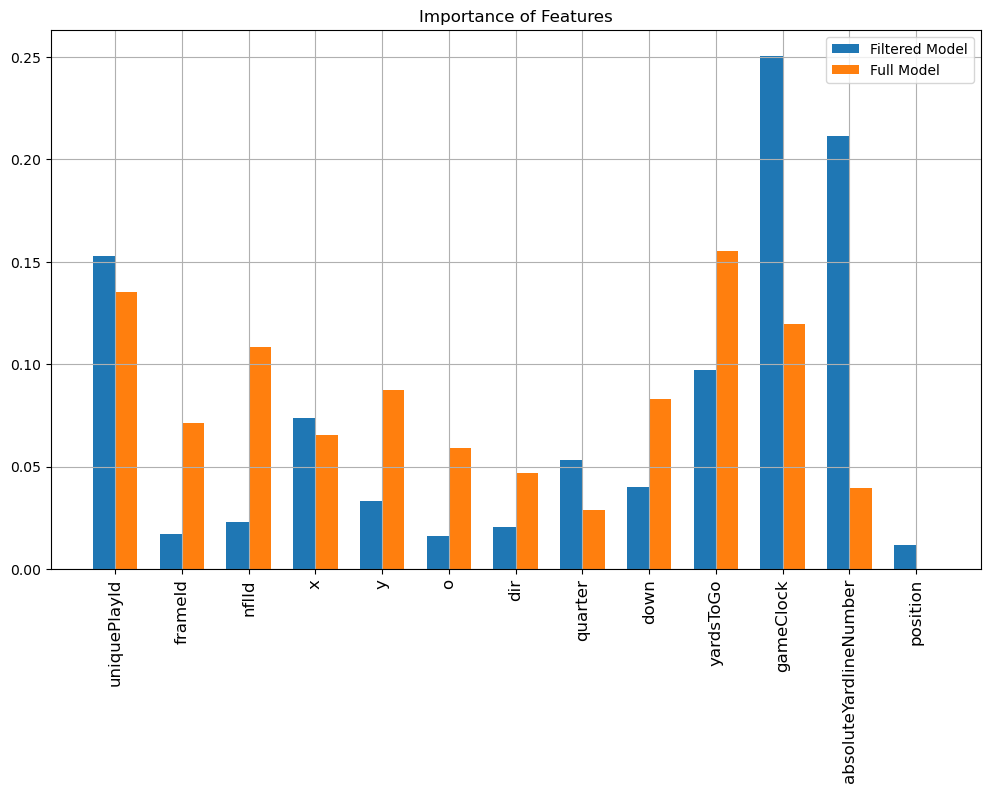

In [216]:
feature_imporances = [model.feature_importances_, modelf.feature_importances_]
columns = [X_train.columns, Xf_train.columns]
group_names = ['Filtered Model', 'Full Model']
plotFeatureImportance(feature_imporances, columns, group_names)

A comparison of these results shows that only having the starting player positions isn't enough to create a good model.<br>

The full model that was able to have a timely view on the data using different `frameIds`, used the "movement" of the players with changing `x`, `y`, orientation (`o`) and direction (`dir`) much more than the filtered model with only the first `frameId`.<br>

For the filtered model, `gameClock` and `absoluteYardlineNumber` were the most important features, but for the full model the `downs` and `yardsToGo` were more important, so the full model is oriented closer to reality.<br>

In [217]:
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.9999652584389167

With 99,9965% accuracy the model is overwhelmingly accurate.<br>
The `RandomForest` algorithm - using all the data - was able to detect the starting position and play process to predict the formation.

In [218]:
yf_pred = modelf.predict(Xf_test)
accuracy_score(yf_test, yf_pred)

0.8199917667751956

On the other hand, the cleaned and stripped down offense dataset is much **more effective** in training time (25 seconds) than the full dataset (over three hours) and has with 80-90% (dependent on the `SMOTE` outcome) also a good accuracy.

### Visualization

In [219]:
def plot_confusion_matrix(cm, target_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [220]:
cm = confusion_matrix(y_test, y_pred)
cmf = confusion_matrix(yf_test, yf_pred)

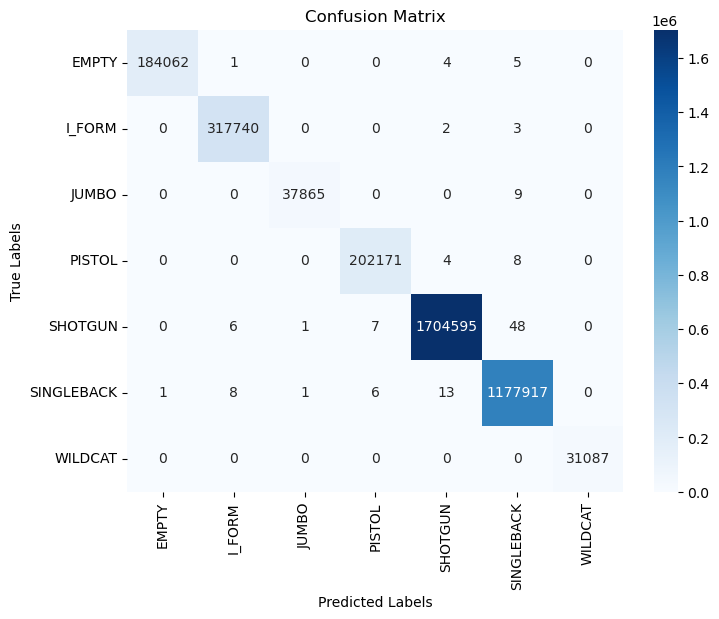

In [221]:
plot_confusion_matrix(cm, target_names)

As **SINGLEBACK** and **SHOTGUN** are still the most common play styles, they were mixed up some times, all others were predicted almost perfectly.

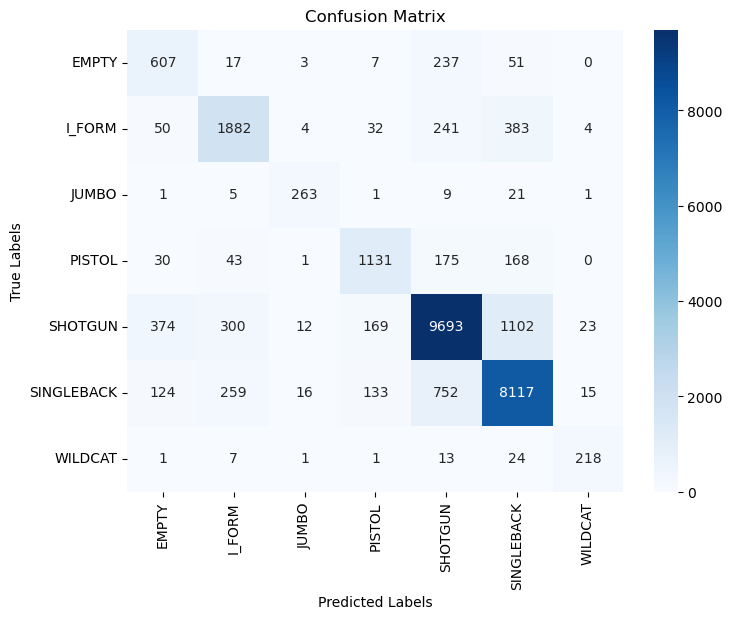

In [222]:
plot_confusion_matrix(cmf, target_names)

The same applies to the filtered model but with an overall worse performance.

In [223]:
def compareValues(y_test, y_pred):
    unique_values, counts = np.unique(y_pred, return_counts=True)
    unique_values_real, counts_real = np.unique(y_test, return_counts=True)

    bar_width = 0.35
    unique_values_real_shifted = unique_values_real + bar_width

    plt.bar(unique_values, counts, width=bar_width, color='skyblue', edgecolor='black', label='Predicted')
    plt.xticks(np.arange(len(target_names)) + bar_width / 2, target_names, rotation=45)
    plt.bar(unique_values_real_shifted, counts_real, width=bar_width, color='green', edgecolor='black', label='True')

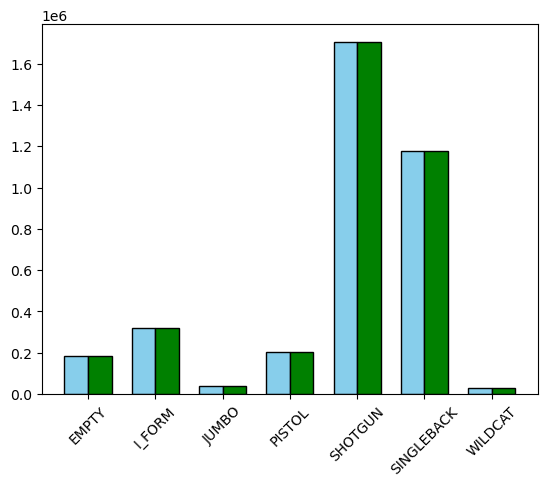

In [224]:
compareValues(y_test, y_pred)

Comparing real and predicted data the all-data model is so accurate you can't see a difference.

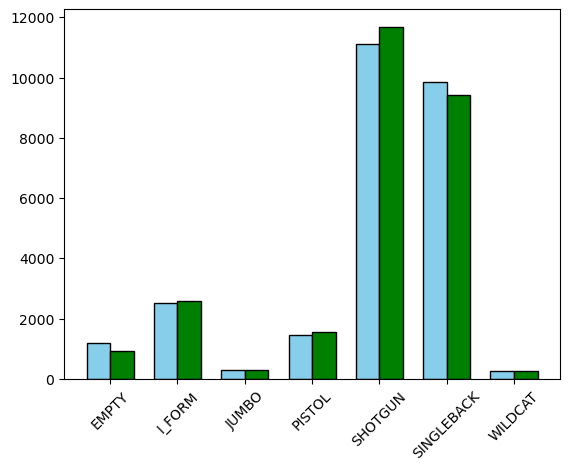

In [225]:
compareValues(yf_test, yf_pred)

For the stripped down model, there are some minor differences in **SINGLEBACK**, **PISTOL** and **JUMBO** formations.

### Conclusion Random Forest

If performance is no concern, the model can be trained with all the data to get an almost perfect prediction, but considering the time, the all data model took **293 times** longer than the stripped down model. This may not be a problem with the current data, but if data from the last few years is available to be analysed, this could lead to performance issues, at least with the technology used here.

Both attempts could be further improved, using parameters like `n_estimators` and `max_depth` to speed up the training with all the data.<br>
For the small model, `GridSearch` or `RandomSearch` can be used for Hyperparameter tuning.

### Hyperparamter tuning using Weights and Biases (WandB)

Using the WandB tool model outcomes can be logged to a web interface and automatical hyperparameter tuning can be done using sweeps.

In [89]:
sweep_config_rf = {
    'method': 'random',  # Random search
    'name': 'sweep',
    'metric': {
        'name': 'accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'n_estimators': {'values': [50, 100, 150]},
        'max_depth': {'values': [None, 2, 4]},
        'min_samples_split': {'values': [2, 4]}
    }
}

In [55]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lukas-zaiser. Use `wandb login --relogin` to force relogin


True

#### Single run using only one set of parameters

In [80]:
def train_random_forest(config=None):
    with wandb.init(project="NFL offense formations", group="HDM_MachineLearning", config=config):
        config = wandb.config
        rf = RandomForestClassifier(
            n_estimators = config['parameters']['n_estimators']['values'][0], #config['n_estimators'],
            max_depth = config['parameters']['max_depth']['values'][0], #config['max_depth'],
            min_samples_split = config['parameters']['min_samples_split']['values'][0] #config['min_samples_split']
        )

        rf.fit(Xf_train, yf_train)
        score = rf.score(Xf_test, yf_test)
        
        # Log the score to wandb
        wandb.log({'accuracy': score})

In [54]:
if (RETRAIN_MODEL):
    train_random_forest(sweep_config_rf)

#### Automatic Hyperparameter tuning using different parameters

In [90]:
if (RETRAIN_MODEL):
    sweep_id_rf = wandb.sweep(sweep=sweep_config_rf, project="NFL offense formations")

Create sweep with ID: 59hjp4r5
Sweep URL: https://wandb.ai/lukas-zaiser/NFL%20offense%20formations/sweeps/59hjp4r5


In [91]:
def train_random_forest_sweep(config=None):
    with wandb.init(group="HDM_MachineLearning"):
        config = wandb.config
        rf = RandomForestClassifier(
            n_estimators = config['n_estimators'],
            max_depth = config['max_depth'],
            min_samples_split = config['min_samples_split']
        )

        rf.fit(Xf_train, yf_train)
        score = rf.score(Xf_test, yf_test)
        
        # Log the score to wandb
        wandb.log({'accuracy': score})

In [55]:
if (RETRAIN_MODEL):
    wandb.agent(sweep_id=sweep_id_rf, function=train_random_forest_sweep, count=10)

In [94]:
wandb.finish()

It took a considerable amount of time to get WandB up and running, as the errors `[WinError 10054] Eine vorhandene Verbindung wurde vom Remotehost geschlossen` and `[WinError 10053] Eine bestehende Verbindung wurde softwaregesteuert durch den Hostcomputer abgebrochen` were constantly displayed and broke the notebook in a way that only a kernel restart was able to fix it.<br>
But after playing around with different versions of the IPython and WandB packages and network settings in Windows it finally worked and the results can be seen in WandB.<br>

<img src="wandb/sweep_config.png" width="100%">

It is very clear that the `max_depth` parameter drastically reduces the accuracy score of the model.

<img src="wandb/sweep_config2.png"  width="100%">

## 5.2 Simple MLP
For neural networks the data had first to be scaled to smaller numbers.<br>
There was no big difference in using `MinMax` or `StandardScaler`.<br>

In the first attempt, a very simple network with only one hidden layer was used.<br>
`SMOTE` could again be used to balance the dataset but this time model weights are trained during model fitting using `compute_class_weight`.<br>

In [56]:
scaler = MinMaxScaler()
# scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Xf_train_scaled = scaler.fit_transform(Xf_train)
Xf_test_scaled = scaler.transform(Xf_test)

In [155]:
def simpleMLP(X, y, input_dim, use_class_weight=False):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(len(np.unique(y)), activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True) # or val_loss

    if use_class_weight == True:
       class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)
       class_weight_dict = {i: class_weights[i] for i in range(len(np.unique(y)))}
       print(class_weight_dict)
       return model.fit(X, y, epochs=5, batch_size=64, validation_split=0.2, callbacks=[early_stopping], class_weight=class_weight_dict) 
    else:
       return model.fit(X, y, epochs=5, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

In [156]:
simpleMLPModel = simpleMLP(Xf_train_scaled, yf_train, len(Xf_train.columns))
simpleMLPModel_weights = simpleMLP(Xf_train_scaled, yf_train, len(Xf_train.columns), use_class_weight=True)

c:\Users\lukas\anaconda3\envs\stats\lib\site-packages\keras\src\engine\data_adapter.py:1808: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



Epoch 1/5
780/780 [==============================] - 2s 1ms/step - loss: 1.3287 - accuracy: 0.4623 - val_loss: 1.2883 - val_accuracy: 0.4664
Epoch 2/5
780/780 [==============================] - 1s 1ms/step - loss: 1.2880 - accuracy: 0.4739 - val_loss: 1.2710 - val_accuracy: 0.4846
Epoch 3/5
780/780 [==============================] - 1s 1ms/step - loss: 1.2764 - accuracy: 0.4790 - val_loss: 1.2621 - val_accuracy: 0.4881
Epoch 4/5
780/780 [==============================] - 1s 1ms/step - loss: 1.2680 - accuracy: 0.4842 - val_loss: 1.2586 - val_accuracy: 0.4917
Epoch 5/5
780/780 [==============================] - 1s 1ms/step - loss: 1.2615 - accuracy: 0.4841 - val_loss: 1.2491 - val_accuracy: 0.4957
{0: 4.026672694394214, 1: 1.5055780933062881, 2: 11.375478927203066, 3: 2.426975476839237, 4: 0.32957152371790127, 5: 0.40141511559781873, 6: 16.106690777576855}
Epoch 1/5
780/780 [==============================] - 1s 1ms/step - loss: 1.8973 - accuracy: 0.1427 - val_loss: 1.8749 - val_accuracy:

### Evaluation

In [157]:
accuracy1 = simpleMLPModel.model.evaluate(np.array(Xf_test_scaled), yf_test)[1]
accuracy2 = simpleMLPModel_weights.model.evaluate(np.array(Xf_test_scaled), yf_test)[1]

print(f'Test Accuracy without weights: {accuracy1 * 100:.2f}%')
print(f'Test Accuracy with weights: {accuracy2 * 100:.2f}%')

  1/836 [..............................] - ETA: 15s - loss: 1.3625 - accuracy: 0.4062

836/836 [==============================] - 1s 727us/step - loss: 1.8502 - accuracy: 0.1963
Test Accuracy without weights: 48.48%
Test Accuracy with weights: 19.63%


### Visualization

In [158]:
predicted_labels = np.argmax(simpleMLPModel.model.predict(Xf_test_scaled), axis=1)
predicted_labels_weights = np.argmax(simpleMLPModel_weights.model.predict(Xf_test_scaled), axis=1)

836/836 [==============================] - 1s 641us/step


In [159]:
cm = confusion_matrix(yf_test, predicted_labels)
cm_weights = confusion_matrix(yf_test, predicted_labels_weights)

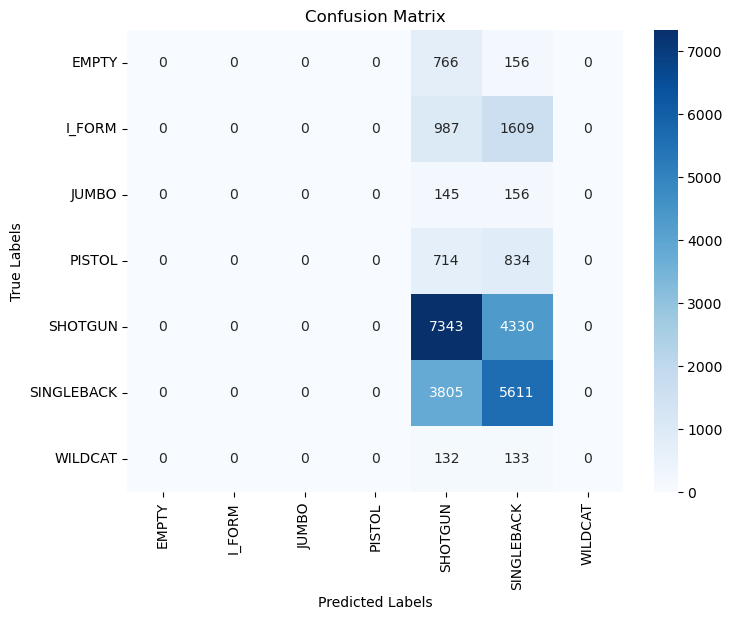

In [166]:
plot_confusion_matrix(cm, target_names)

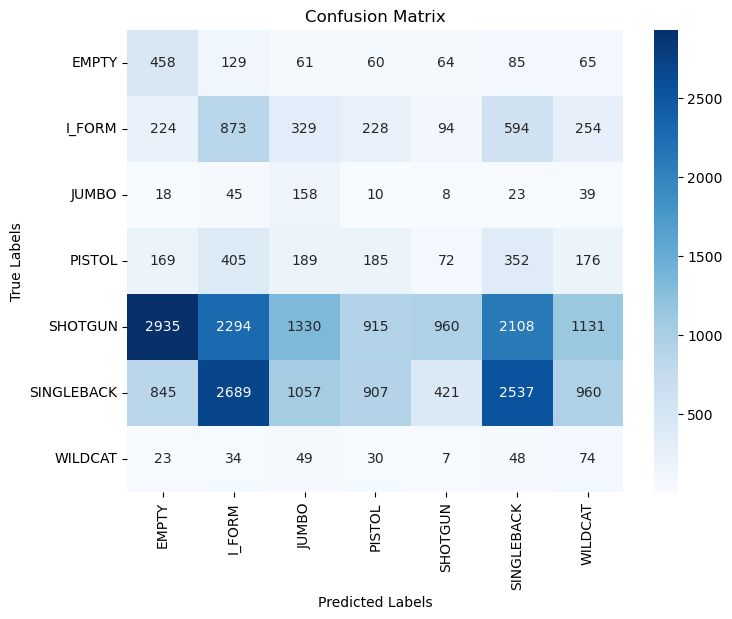

In [167]:
plot_confusion_matrix(cm_weights, target_names)

In [177]:
# Compute accuracy for each class
class_accuracy = np.diag(cm_weights) / cm_weights.sum(axis=1)
class_accuracy_dict = {f'{target_names[i]}': acc for i, acc in enumerate(class_accuracy)}
for class_label, accuracy in class_accuracy_dict.items():
    print(f"{class_label}: {accuracy*100:.2f}")

EMPTY: 49.67
I_FORM: 33.63
JUMBO: 52.49
PISTOL: 11.95
SHOTGUN: 8.22
SINGLEBACK: 26.94
WILDCAT: 27.92


The training took only a couple of seconds.

The accuracy for the model **without weights** is at 48% but only because it always predicts the most common classes (**SHOTGUN** and **SINGLEBACK**).<br>
Therefore this model has no use at all.

The accuracy for the model **with weights** is below 20% and has a wide range of predictions:

- **SHOTGUN** was predicted correctly in only ~8% of the cases, most of the time is got mixed up with **EMPTY**, **I_FORM** or **SINGLEBACK**
- **EMPTY** and **JUMBO** was predicted correctly in around 50% of the cases, but **EMPTY** together with **I_FORM** and **SINGLEBACK** were falsely predicted a lot of times

### Conclusion

The simple model performs pretty bad, especially in comparison with the `RandomForest` models.<br>
One alternative is using an `LSTM` and take the time (`frameId`) of the play into account.

## 5.3 Bi-directional LSTM

To keep things simple, only the first seven frames are taken into consideration because every play has them or else complex padding would be required.

In [102]:
df[df['frameId'] < 10].groupby('frameId').count()

,uniquePlayId,nflId,x,y,o,dir,quarter,down,yardsToGo,gameClock,absoluteYardlineNumber,position
frameId,,,,,,,,,,,,
1,287020,287020,287020,287020,287020,287020,287020,287020,287020,287020,287020,287020
2,287020,287020,287020,287020,287020,287020,287020,287020,287020,287020,287020,287020
3,287020,287020,287020,287020,287020,287020,287020,287020,287020,287020,287020,287020
4,287020,287020,287020,287020,287020,287020,287020,287020,287020,287020,287020,287020
5,287020,287020,287020,287020,287020,287020,287020,287020,287020,287020,287020,287020
6,287020,287020,287020,287020,287020,287020,287020,287020,287020,287020,287020,287020
7,287020,287020,287020,287020,287020,287020,287020,287020,287020,287020,287020,287020
8,286997,286997,286997,286997,286997,286997,286997,286997,286997,286997,286997,286997
9,286997,286997,286997,286997,286997,286997,286997,286997,286997,286997,286997,286997


In [114]:
NUMBER_OF_FRAMES = 7

In [103]:
def FilterAndScale(df, y, max_frames):
    max_frames += 1
    dfc = df.copy()
    dfc['y_label'] = y
    dfc = dfc[dfc['frameId'] < max_frames]
    yc = dfc.pop('y_label')

    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(dfc)
    return (pd.DataFrame(df_scaled, columns=df.columns), yc)

In [104]:
if (RETRAIN_MODEL):
    scaled_df, y_padded = FilterAndScale(df, y, max_frames=NUMBER_OF_FRAMES)

In [105]:
scaled_df.groupby('frameId').count()

,uniquePlayId,nflId,x,y,o,dir,quarter,down,yardsToGo,gameClock,absoluteYardlineNumber,position
frameId,,,,,,,,,,,,
-1.5,287020,287020,287020,287020,287020,287020,287020,287020,287020,287020,287020,287020
-1.0,287020,287020,287020,287020,287020,287020,287020,287020,287020,287020,287020,287020
-0.5,287020,287020,287020,287020,287020,287020,287020,287020,287020,287020,287020,287020
0.0,287020,287020,287020,287020,287020,287020,287020,287020,287020,287020,287020,287020
0.5,287020,287020,287020,287020,287020,287020,287020,287020,287020,287020,287020,287020
1.0,287020,287020,287020,287020,287020,287020,287020,287020,287020,287020,287020,287020
1.5,287020,287020,287020,287020,287020,287020,287020,287020,287020,287020,287020,287020


The train test split is not shuffled as the sorted list of `uniquePlayId` and `frameId` is required to make packages of 7 frames.<br>
This way the `stats.mode` will return the correct value for y (`position`), as the `position` is always the same value for one `uniquePlayId`.<br>
With shuffeled data the timeframe would make no sense as different data gets matched together.

The only downside is that overlapping data (like game 1 frame 0-4, 2-6 and so on) is lost, but with 7 frames padding would be required again.

In [132]:
if (RETRAIN_MODEL):
    X_train, X_test, y_train, y_test = train_test_split(scaled_df, y_padded, test_size=0.3, random_state=42, shuffle=False)

In [142]:
from scipy import stats
def create_timestamps(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        _x = X.iloc[i:(i + time_steps)].values
        _y = y.iloc[i:(i + time_steps)]
        Xs.append(_x)
        ys.append(stats.mode(_y)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

if (RETRAIN_MODEL):
    X_train_ts, y_train_ts = create_timestamps(X_train, y_train, time_steps=NUMBER_OF_FRAMES, step=NUMBER_OF_FRAMES)
    X_test_ts, y_test_ts = create_timestamps(X_test, y_test, time_steps=NUMBER_OF_FRAMES, step=NUMBER_OF_FRAMES)

C:\Users\lukas\AppData\Local\Temp\ipykernel_12812\2366930358.py:8: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



In [144]:
if (RETRAIN_MODEL):
    np.savez('testsplit2_ts', X_train=X_train_ts, y_train=y_train_ts, X_test=X_test_ts, y_test=y_test_ts)

In [184]:
loaded_data = np.load("testsplit2_ts.npz", allow_pickle=True)
X_train_ts = loaded_data['X_train']
y_train_ts = loaded_data['y_train']
X_test_ts = loaded_data['X_test']
y_test_ts = loaded_data['y_test']

Now the data is in the required shape, with (`number of data entries`, `number of time frames`, `number of features`)

In [143]:
print(X_train_ts.shape, y_train_ts.shape)
print(X_test_ts.shape, y_test_ts.shape)

(200913, 7, 13) (200913, 1)
(86105, 7, 13) (86105, 1)


In [145]:
unique_values, counts = np.unique(y_train_ts, return_counts=True)
for value, count in zip(unique_values, counts):
    print(f"Class {value}: {count}")

Class 0: 13984
Class 1: 14950
Class 2: 2024
Class 3: 9177
Class 4: 102035
Class 5: 57570
Class 6: 1173


In [146]:
model = Sequential()
model.add(Bidirectional(LSTM(128, input_shape=(5, len(X_train.columns)), activation='relu')))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(len(np.unique(yf_train)), activation='softmax'))

early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True) # or val_loss
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(yf_train), y=y_train_ts.flatten())
class_weight_dict = {i: class_weights[i] for i in range(len(np.unique(yf_train)))}

history = model.fit(X_train_ts, y_train_ts, epochs=5, batch_size=22, validation_split=0.3, callbacks=[early_stopping], class_weight=class_weight_dict)

Epoch 1/5
6393/6393 [==============================] - 25s 4ms/step - loss: 1.5222 - accuracy: 0.2121 - val_loss: 1.6954 - val_accuracy: 0.2041
Epoch 2/5
6393/6393 [==============================] - 23s 4ms/step - loss: 1.3802 - accuracy: 0.2008 - val_loss: 1.7051 - val_accuracy: 0.1971
Epoch 3/5
6393/6393 [==============================] - 23s 4ms/step - loss: 1.2941 - accuracy: 0.1960 - val_loss: 1.7778 - val_accuracy: 0.1879


### Evaluation

In [147]:
print('History:', history.history['accuracy'])
accuracy = history.model.evaluate(X_test_ts, y_test_ts)[1]
print(f'Test Accuracy: {accuracy * 100:.2f}%')

History: [0.21206778287887573, 0.20079778134822845, 0.19597692787647247]
2691/2691 [==============================] - 5s 2ms/step - loss: 1.6968 - accuracy: 0.1972
Test Accuracy: 19.72%


### Visualization

In [148]:
predicted_labels = np.argmax(history.model.predict(X_test_ts), axis=1)

2691/2691 [==============================] - 5s 2ms/step


In [149]:
cm = confusion_matrix(y_test_ts, predicted_labels)

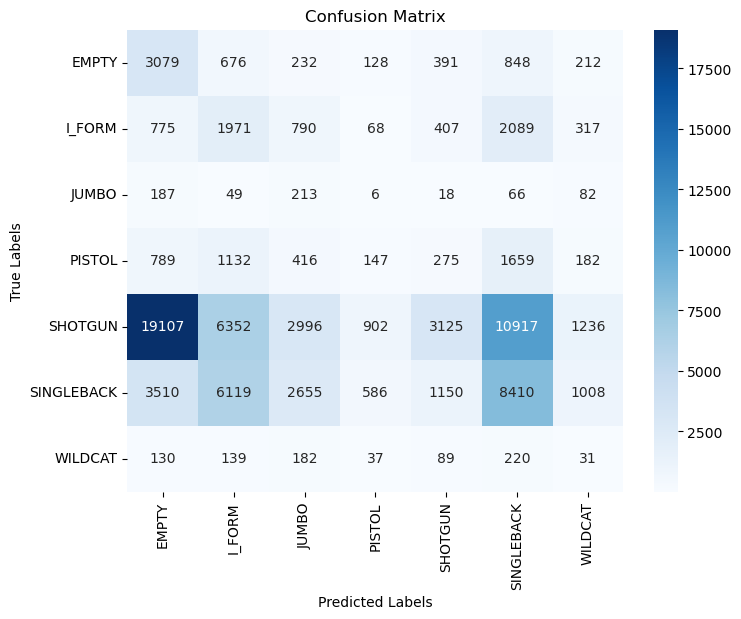

In [152]:
plot_confusion_matrix(cm, target_names)

### Conclusion

The bi-directional `LSTM` with time series data **without weights** achieved an accuracy of ~72%, BUT it predicted always the same class (**SHOTGUN**), therefore it has no use at all.<br>
Using weights, the accuracy dropped to 19.72% and the predictions are wide spread again. **EMPTY** was predicted a lot and therefore there are some lucky true positives for this formation.

Even with the complex `LSTM` and data preprocessing, the model result is pretty much the same as with the simple MLP.<br>
It seems this type of data is not well suited for deep learning models.

# 6. Short Excursion: Transformer / Decoder / ChatGPT

In [91]:
from langchain.prompts import ChatPromptTemplate
from langchain.chat_models import ChatOpenAI
import os
import openai
 
openai.api_key = os.environ['OPENAI_API_KEY']

In [92]:
df_plays = pd.read_csv("data/2022/plays.csv")
df_plays['playDescription'].values

array(['(7:52) (Shotgun) M.Mariota pass short middle to P.Hesse to 50 for 9 yards (K.Neal).',
       '(7:38) (Shotgun) C.Claypool right end to PIT 37 for 3 yards (C.Awuzie).',
       '(8:57) D.Carr pass short middle to D.Waller to LV 45 for 15 yards (N.Adderley).',
       ...,
       '(9:35) (Shotgun) J.Mixon left end to CIN 47 for 6 yards (C.Harris, D.Davis).',
       '(2:02) (Shotgun) J.Taylor up the middle to TEN 36 for -2 yards (D.Long, J.Schobert).',
       '(12:51) C.Heck reported in as eligible.  D.Pierce up the middle to LV 14 for 3 yards (D.Perryman; D.Deablo).'],
      dtype=object)

In [93]:
llm_model = "gpt-4-1106-preview"
llm = ChatOpenAI(temperature=0.0, model=llm_model)

In [94]:
test_input = df_full[:10]
test_input

,uniquePlayId,gameId,playId,frameId,nflId,playDirection,x,y,o,dir,...,possessionTeam,offenseFormation,absoluteYardlineNumber,attacker,height,weight,birthDate,collegeName,position,displayName
0,202209080056,2022090800,56,1,35472.0,left,88.37,27.27,231.74,147.90,...,BUF,SHOTGUN,85,True,6-5,325.0,1988-06-06,Indiana,G,Rodger Saffold
1,202209080056,2022090800,56,2,35472.0,left,88.47,27.13,230.98,148.53,...,BUF,SHOTGUN,85,True,6-5,325.0,1988-06-06,Indiana,G,Rodger Saffold
2,202209080056,2022090800,56,3,35472.0,left,88.56,27.01,230.98,147.05,...,BUF,SHOTGUN,85,True,6-5,325.0,1988-06-06,Indiana,G,Rodger Saffold
3,202209080056,2022090800,56,4,35472.0,left,88.64,26.90,232.38,145.42,...,BUF,SHOTGUN,85,True,6-5,325.0,1988-06-06,Indiana,G,Rodger Saffold
4,202209080056,2022090800,56,5,35472.0,left,88.72,26.80,233.36,141.95,...,BUF,SHOTGUN,85,True,6-5,325.0,1988-06-06,Indiana,G,Rodger Saffold
5,202209080056,2022090800,56,6,35472.0,left,88.80,26.70,234.48,139.41,...,BUF,SHOTGUN,85,True,6-5,325.0,1988-06-06,Indiana,G,Rodger Saffold
6,202209080056,2022090800,56,7,35472.0,left,88.87,26.64,235.77,134.32,...,BUF,SHOTGUN,85,True,6-5,325.0,1988-06-06,Indiana,G,Rodger Saffold
7,202209080056,2022090800,56,8,35472.0,left,88.91,26.59,240.00,131.01,...,BUF,SHOTGUN,85,True,6-5,325.0,1988-06-06,Indiana,G,Rodger Saffold
8,202209080056,2022090800,56,9,35472.0,left,88.94,26.57,243.56,122.29,...,BUF,SHOTGUN,85,True,6-5,325.0,1988-06-06,Indiana,G,Rodger Saffold
9,202209080056,2022090800,56,10,35472.0,left,88.95,26.58,246.07,85.87,...,BUF,SHOTGUN,85,True,6-5,325.0,1988-06-06,Indiana,G,Rodger Saffold


In [95]:
template_string = """Make a summary of an american football play \
Here is an example: (<time of game>) (<offense formation>) <what happens in the play>. \
Use the format of the example to create a new text using only this data: ```{text}```
"""

In [96]:
prompt_template = ChatPromptTemplate.from_template(template_string)
customer_messages = prompt_template.format_messages(text=test_input.to_json())

In [97]:
customer_response = llm(customer_messages)

In [98]:
print(customer_response.content)

(1st Quarter) (SHOTGUN) Buffalo Bills' guard Rodger Saffold (#35472, 6-5, 325 lbs, Indiana) lines up and moves to the left as the play develops. The offense is in a shotgun formation at the 15-yard line with 10 yards to go. The play is directed towards the left side of the field. Throughout the play, Saffold's orientation and direction shift as he engages in blocking to protect the quarterback and create space for the play. Despite the changes in his movement and direction, the team maintains its attacking posture, with Saffold playing a crucial role on the offensive line.


Output with only one frame:

- (900) (SHOTGUN) Rodger Saffold, a 6-5, 325-pound offensive lineman from Indiana, playing for the Buffalo Bills, lines up at left guard. The play is in the first quarter with 10 yards to go for a first down. The game clock shows 15 minutes remaining. The offense is moving left. Saffold is positioned at the 88.37-yard line, with a direction of 231.74 degrees. The play is about to begin.

Output with multiple frames:

- On September 8th, in a game between the Buffalo Bills and an unknown opponent, there was a play that occurred at the 56th minute. The offense formation was in the shotgun. The play started with the ball at the 85-yard line. The offensivePlayer, Rodger Saffold, who is 6-5 and weighs 325 pounds, was in position as a guard. The play was directed towards the left side. Saffold's initial position was at coordinates (88.37, 27.27) on the field. He had an orientation of 231.74 degrees and was moving in the direction of 147.9 degrees. The game clock showed 900 seconds remaining in the first quarter, and it was first down with 10 yards to go. The possession team was the Buffalo Bills.

GPT is great at generating texts, but can it also help with the task at hand?

In [99]:
def getOffenseFormation(df):
    test_input = df.drop(columns=['offenseFormation'])
    test_input = test_input[test_input['offensivePlayer'] == True]
    template_string = """Possible offense formations are: SHOTGUN, SINGLEBACK, I_FORM, EMPTY, PISTOL, JUMBO or WILDCAT. \
         Your job is to analyze the data and output the offense formation of the play.
         You're given information about the position of the players (x, y) on the field (0-120 and 0 - 53.3). \
         In addition the role of the players (QB being quarterback and so on). \
         Output only the name of the offense formation of the current play specified by this data: \ ```{text}```"""
    prompt_template = ChatPromptTemplate.from_template(template_string)
    customer_messages = prompt_template.format_messages(text=test_input.to_json())
    customer_response = llm(customer_messages)
    print(customer_response.content)

In [100]:
getOffenseFormation(play1) # should be I_FORM
getOffenseFormation(play2) # should be SHOTGUN

To determine the offensive formation, we need to analyze the positions of the players on the field, particularly the backfield arrangement and the distribution of wide receivers, tight ends, and running backs. Here's a breakdown of the key characteristics of each formation:

- SHOTGUN: The quarterback (QB) is lined up several yards behind the center. There may be running backs (RB) or wide receivers (WR) near the QB, but the key is the QB's depth.
- SINGLEBACK: There is only one running back in the backfield, and the QB is under center.
- I_FORM: The QB is under center with a fullback (FB) and a running back (RB) lined up directly behind him in a line (forming an "I").
- EMPTY: No players are in the backfield with the QB; all potential ball carriers are lined up as wide receivers or tight ends.
- PISTOL: Similar to the shotgun, but the QB is not as deep, and there is typically a running back directly behind the QB.
- JUMBO: This is a power formation with extra linemen or tight ends, an

First output which should be **I_FORM**:

```
To determine the offensive formation, we need to analyze the positions of the players on the field, particularly the backfield arrangement and the distribution of wide receivers (WRs), tight ends (TEs), and running backs (RBs). Here's a breakdown of the key characteristics of each formation:

- SHOTGUN: The QB is several yards behind the center. There can be RBs or WRs near the QB or spread out, but the key is the QB's depth.
- SINGLEBACK: There is only one RB in the backfield, typically directly behind the QB, who is under center.
- I_FORM: The QB is under center with a fullback (FB) and RB lined up directly behind him in a line, forming an "I" shape.
- EMPTY: No RBs in the backfield; the QB is either under center or in shotgun, with all other players spread out as WRs or TEs.
- PISTOL: Similar to the shotgun, but the QB is not as deep, and there is typically an RB directly behind the QB.
- JUMBO: A power-running formation with extra linemen, TEs, or a fullback, usually with a tight formation and the QB under center.
- WILDCAT: A non-QB (often an RB) takes the snap, and the QB is either lined up as a WR or not on the field.

Given the data, we can start by identifying the QB's position and then look at the surrounding players. Here's the relevant data extracted from the JSON:

- QB (position "QB"): x=73.67, y=23.77
- RB (position "RB"): x=67.58, y=23.76
- WR (position "WR"): x=74.11, y=43.91
- TEs (position "TE"): x=72.58, y=19.91 and x=73.12, y=17.93
- Remaining positions are linemen (T, C, G) and are typically on the line of scrimmage.

The QB is not far behind the line of scrimmage, which suggests he is not in a deep shotgun position. There is one RB positioned close to the QB, which could indicate a PISTOL or SINGLEBACK formation. However, the RB is not directly behind the QB, which is more typical of the PISTOL formation. There is one WR far out, and two TEs are close to the line, which does not suggest an EMPTY formation.

Given the QB's position and the RB's relative position, the formation seems to be PISTOL. The presence of TEs close to the line and a WR spread out supports this, as the PISTOL formation can accommodate tight ends and allows for a running back to be positioned directly behind the quarterback, ready for a handoff or pass protection.

Therefore, the offensive formation for the current play is likely PISTOL.
```

Second output which should be **SHOTGUN**:

```
To determine the offensive formation, we need to analyze the positions of the players on the field. The provided data includes the x (horizontal) and y (vertical) coordinates of each player, their role (position), and additional information such as the direction of play and whether they are on the attacking team.

Here's a breakdown of the key positions and their typical locations in various formations:

- QB (Quarterback): Usually lines up directly behind the center or a few yards back in shotgun or pistol formations.
- RB (Running Back): Can be directly behind the QB in I_FORM, next to or behind the QB in PISTOL, or in various locations in other formations.
- WR (Wide Receiver): Typically spread out wide on either side of the formation.
- TE (Tight End): Lines up next to the offensive line, can be on the line or slightly off the line.
- C (Center): Snaps the ball to the QB, located in the middle of the offensive line.
- G (Guard): Flanks the center on either side.
- T (Tackle): Flanks the guards and are the outermost linemen.

Let's analyze the provided data:

- The QB (#372454) is at x=30.05, y=32.81, which suggests he is behind the center but not deep enough for a typical shotgun or pistol formation.
- The RB (#372748) is at x=33.81, y=16.47, which is behind the QB, indicating a possible I_FORM or SINGLEBACK formation.
- The WRs (#372643, #372685, #372811) are spread out, with one (#372643) being quite far from the line (x=35.96, y=40.41), which is typical for a WR.
- The TE (#372769) is at x=33.78, y=28.88, which is close to the line, suggesting a traditional TE position.
- The C (#372622) is at x=35.02, y=25.36, which is consistent with the center position.
- The Gs (#372517, #372727) and Ts (#372601, #372790) are positioned in a line with the center, which is typical for an offensive line setup.

Given the positions of the RB and the QB, as well as the traditional setup of the offensive line and the spread of the WRs, this formation is most likely an I_FORM, where the RB lines up directly behind the QB, who is under center.

Therefore, the offensive formation for the current play is I_FORM.
```

### Conclusion

Using `GPT 3.5 turbo` the AI wasn't able to output any useful information about the play.<br>
With `GPT 4.0` the model was able to understand the task and analyze the data much better but resulting in different results than expected from the data.

The Transformer is great to generate text and was able to analyze the data pretty convincingly, but the results do not match.<br>
Therefore using a tranditional machine learning approach is better in this case, although it's impressive how well the zero shot learning works.

# 7. Discussion and final conclusion

The prediction of offensive plays using positional data as well as game data worked very well when using the `RandomForest` algorithm.<br>
Especially yards to go and game clock were important parameters to predict the formation.<br>
Altough the data was not entirely clean, using all the data resulted in a nearly perfect model with **99.99% accuracy**, but it took over three hours to compute.<br>
After cleaning the data and only keeping correct starting positions, a lot of data was unfortunately lost. The model training was a lot faster but the accuracy also went down to **~80%**.<br>
Because the dataset is imbalanced, `SMOTE` was used to generate more samples of the underrepresented classes. This component seems to act randomly, resulting in different model outcomes.<br>

Using WandB, further tuning of the models is possible, especially when using sweeps for automatic hyperparameter tuning. The results and diagrams in the WandB UI are helpful for further optimizations especially for the filtered data approach.<br>
The only downside was that there was a lot of trouble setting things up because of some network issues on windows systems.<br>

Another approach using deep learning wasn't successful. A very simple model achieved only **~20% accuracy**.<br>
After extensive data preparation using the given timeframes of the data (`frameId`) using an `LSTM` didn't yield better results.<br>
It seems that those models have different strengths (images, speech) and are not the best fit for this type of structured and unbalanced data.<br>

A short example using the Transformer GPT models showed that those general purpose models are not good for directly generating correct results, but especially `GPT 4.0` can help a lot to better understand the topic and what is required to get good results.<br>
Most likely the given initial promt also wasn't perfect, so here would be some room for improvements, too.<br>

All in all a lot of different topics, approaches and models were tested and a lot of experiments were conducted.<br>
In addition to a great deal of technical expertise, new insights into the theory of American football were gained.<br>
<br>
<img src="football_img.jpg" width="100%">